In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s3e20/sample_submission.csv
/kaggle/input/playground-series-s3e20/train.csv
/kaggle/input/playground-series-s3e20/test.csv
/kaggle/input/train-test-processed/train_proc.csv
/kaggle/input/train-test-processed/test_proc.csv


# Problem Understanding

We are trying to predict carbon emissions in Rwanda (country in Africa) based on historical data. The data is based on 3 years of data from 2019 - 2021. We have 7 main features including:

- Sulphur Dioxide
- Carbon Monoxide
- Nitrogen Dioxide
- Formaldehyde
- UV Aerosol Index
- Ozone
- Cloud

Each of these features have sub-features that was calculated using DOAS technique. The sub-features were measured by [Sentinel-5P](https://sentinels.copernicus.eu/web/sentinel/missions/sentinel-5p) satellite and preproceesed by harpconvert. Furthermore, there are 497 unique locations that were selected from areas in Rwanda for measuring the emission that are indentified using the latitude and longitude.

Huge thanks to [Ambrosm](https://www.kaggle.com/code/ambrosm/pss3e20-eda-which-makes-sense/notebook) for inspiring this notebook.

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# 1. Importing Dataset

In [3]:
train = pd.read_csv('/kaggle/input/playground-series-s3e20/train.csv',
                    index_col='ID_LAT_LON_YEAR_WEEK')
test = pd.read_csv('/kaggle/input/playground-series-s3e20/test.csv',
                   index_col='ID_LAT_LON_YEAR_WEEK')
print('# of rows and columns in train:',train.shape)
print('# of rows and columns in test:',test.shape)

# of rows and columns in train: (79023, 75)
# of rows and columns in test: (24353, 74)


In [4]:
train.head()

,latitude,longitude,year,week_no,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,SulphurDioxide_sensor_zenith_angle,...,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle,emission
ID_LAT_LON_YEAR_WEEK,,,,,,,,,,,,,,,,,,,,,
ID_-0.510_29.290_2019_00,-0.51,29.29,2019,0,-0.000108,0.603019,-0.000065,0.255668,-98.593887,50.843559,...,3664.436218,61085.809570,2615.120483,15.568533,0.272292,-12.628986,35.632416,-138.786423,30.752140,3.750994
ID_-0.510_29.290_2019_01,-0.51,29.29,2019,1,0.000021,0.728214,0.000014,0.130988,16.592861,39.137194,...,3651.190311,66969.478735,3174.572424,8.690601,0.256830,30.359375,39.557633,-145.183930,27.251779,4.025176
ID_-0.510_29.290_2019_02,-0.51,29.29,2019,2,0.000514,0.748199,0.000385,0.110018,72.795837,52.868816,...,4216.986492,60068.894448,3516.282669,21.103410,0.251101,15.377883,30.401823,-142.519545,26.193296,4.231381
ID_-0.510_29.290_2019_03,-0.51,29.29,2019,3,NaN,NaN,NaN,NaN,NaN,NaN,...,5228.507736,51064.547339,4180.973322,15.386899,0.262043,-11.293399,24.380357,-132.665828,28.829155,4.305286
ID_-0.510_29.290_2019_04,-0.51,29.29,2019,4,-0.000079,0.676296,-0.000048,0.121164,4.121269,35.515587,...,3980.598120,63751.125781,3355.710107,8.114694,0.235847,38.532263,37.392979,-141.509805,22.204612,4.347317


## a. Features Check

In [5]:
features_dict = dict()
for i in train.columns.to_list()[5:-1]:
    name = i.split('_')[0]
    if name not in features_dict:
        features_dict[name] = 0
    else:
        features_dict[name] += 1
        
features_dict

{'SulphurDioxide': 7,
 'CarbonMonoxide': 7,
 'NitrogenDioxide': 11,
 'Formaldehyde': 7,
 'UvAerosolIndex': 5,
 'Ozone': 8,
 'UvAerosolLayerHeight': 6,
 'Cloud': 10}

In [6]:
features_dict = dict()
for i in test.columns.to_list()[5:]:
    name = i.split('_')[0]
    if name not in features_dict:
        features_dict[name] = 0
    else:
        features_dict[name] += 1
        
features_dict

{'SulphurDioxide': 7,
 'CarbonMonoxide': 7,
 'NitrogenDioxide': 11,
 'Formaldehyde': 7,
 'UvAerosolIndex': 5,
 'Ozone': 8,
 'UvAerosolLayerHeight': 6,
 'Cloud': 10}

The test and train set have the same name and # of features. We got UvAerosolLayerHeight above as an extra main feature that were not specified in the main features. We can say that the main features share approximately 5 same sub-features. There were additional sub-features for some main features.

In [7]:
print('All columns:')
for num, i in enumerate(train.columns):
    print(num, i)

All columns:
0 latitude
1 longitude
2 year
3 week_no
4 SulphurDioxide_SO2_column_number_density
5 SulphurDioxide_SO2_column_number_density_amf
6 SulphurDioxide_SO2_slant_column_number_density
7 SulphurDioxide_cloud_fraction
8 SulphurDioxide_sensor_azimuth_angle
9 SulphurDioxide_sensor_zenith_angle
10 SulphurDioxide_solar_azimuth_angle
11 SulphurDioxide_solar_zenith_angle
12 SulphurDioxide_SO2_column_number_density_15km
13 CarbonMonoxide_CO_column_number_density
14 CarbonMonoxide_H2O_column_number_density
15 CarbonMonoxide_cloud_height
16 CarbonMonoxide_sensor_altitude
17 CarbonMonoxide_sensor_azimuth_angle
18 CarbonMonoxide_sensor_zenith_angle
19 CarbonMonoxide_solar_azimuth_angle
20 CarbonMonoxide_solar_zenith_angle
21 NitrogenDioxide_NO2_column_number_density
22 NitrogenDioxide_tropospheric_NO2_column_number_density
23 NitrogenDioxide_stratospheric_NO2_column_number_density
24 NitrogenDioxide_NO2_slant_column_number_density
25 NitrogenDioxide_tropopause_pressure
26 NitrogenDioxide_ab

Except the main features we have:
- Latitude and Longitude (identifier for unique locations)
- Week No (time-series week each year)
- Year

It is important to note that the main features are measurement of gasses in the air that was captured by the satellite. Satellite might not be directly under the area where measurement is done.

# 2. EDA

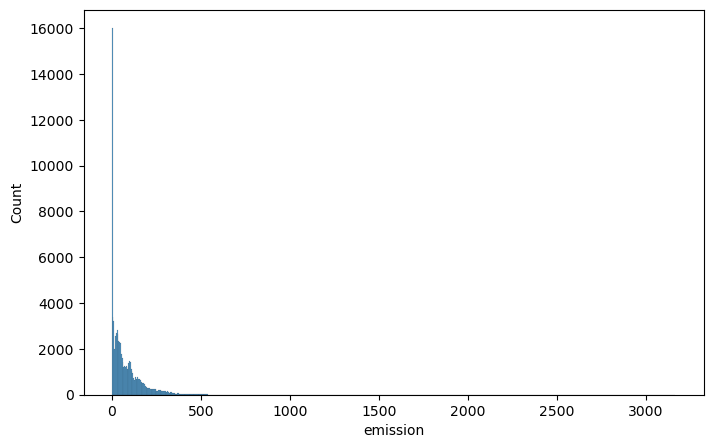

In [8]:
plt.figure(figsize=(8,5))
sns.histplot(x='emission', data=train)
plt.show()

The target distribution has skewed right distribution. It seems that there are a lot of values around 0.

## a. Checking Correlations

In [9]:
with pd.option_context('display.min_rows', 20):
    display(train.corr()[['emission']].sort_values('emission', ascending=False))

,emission
emission,1.000000
longitude,0.102746
UvAerosolLayerHeight_aerosol_height,0.069008
Cloud_surface_albedo,0.046587
Formaldehyde_tropospheric_HCHO_column_number_density_amf,0.040263
UvAerosolLayerHeight_aerosol_optical_depth,0.040156
UvAerosolLayerHeight_sensor_azimuth_angle,0.035142
NitrogenDioxide_sensor_altitude,0.027540
NitrogenDioxide_cloud_fraction,0.022456
NitrogenDioxide_absorbing_aerosol_index,0.020905


Above are the independent variables correlation with the target variable. It is obvious that they are not strongly correlated either way. Thus, it might be a good idea to capture the non-linearity trend of the data by capturing seasonality, pattern, etc. 

## b. Checking Null Values

In [10]:
with pd.option_context('display.min_rows', 20):
    display(train.isna().sum().sort_values())

latitude                                                      0
week_no                                                       0
emission                                                      0
longitude                                                     0
year                                                          0
Cloud_solar_zenith_angle                                    484
Cloud_cloud_top_pressure                                    484
Cloud_cloud_top_height                                      484
Cloud_cloud_base_pressure                                   484
Cloud_cloud_fraction                                        484
                                                          ...  
NitrogenDioxide_solar_azimuth_angle                       18320
NitrogenDioxide_tropospheric_NO2_column_number_density    18320
NitrogenDioxide_solar_zenith_angle                        18320
UvAerosolLayerHeight_sensor_zenith_angle                  78584
UvAerosolLayerHeight_solar_azimuth_angle

So we have a lot of missing values here. `UvAerosolLayerHeight` has almost missing values in all rows. We need a way to impute this missing values or decide to remove the column (not the rows as we are dealing with time series data).

In [11]:
def create_null_df(data):
    null_df = pd.DataFrame(data.isnull().sum(), columns=['Total'])
    null_df['%NullValues'] = round((null_df['Total']/data.shape[0])*100, 2)  
    null_df = null_df[null_df['Total']!=0]
    return null_df.sort_values('Total', ascending=False)

null_df_train = create_null_df(train)
with pd.option_context('display.min_rows', 20):
#     display(null_df_train)
    display(null_df_train.style.background_gradient(axis=0))

,Total,%NullValues
UvAerosolLayerHeight_aerosol_pressure,78584,99.440000
UvAerosolLayerHeight_solar_zenith_angle,78584,99.440000
UvAerosolLayerHeight_aerosol_height,78584,99.440000
UvAerosolLayerHeight_aerosol_optical_depth,78584,99.440000
UvAerosolLayerHeight_sensor_zenith_angle,78584,99.440000
UvAerosolLayerHeight_sensor_azimuth_angle,78584,99.440000
UvAerosolLayerHeight_solar_azimuth_angle,78584,99.440000
NitrogenDioxide_NO2_slant_column_number_density,18320,23.180000
NitrogenDioxide_tropopause_pressure,18320,23.180000
NitrogenDioxide_tropospheric_NO2_column_number_density,18320,23.180000


In [12]:
null_df_test = create_null_df(test)
with pd.option_context('display.min_rows', 20):
    display(null_df_test.style.background_gradient(axis=0))

,Total,%NullValues
UvAerosolLayerHeight_aerosol_pressure,22260,91.410000
UvAerosolLayerHeight_solar_zenith_angle,22260,91.410000
UvAerosolLayerHeight_aerosol_height,22260,91.410000
UvAerosolLayerHeight_aerosol_optical_depth,22260,91.410000
UvAerosolLayerHeight_sensor_zenith_angle,22260,91.410000
UvAerosolLayerHeight_sensor_azimuth_angle,22260,91.410000
UvAerosolLayerHeight_solar_azimuth_angle,22260,91.410000
SulphurDioxide_SO2_column_number_density_amf,6142,25.220000
SulphurDioxide_SO2_column_number_density,6142,25.220000
SulphurDioxide_SO2_column_number_density_15km,6142,25.220000


The missing values are similar for test and train set. `UvAerosolLayerHeight` has a lot of missing values in both test and train set, so we can consider dropping the columns related. For other columns, the highest % missing values are ~21% of data in both sets. We can try imputing them with interpolation or bfill/ffill when appropriate. Otherwise we could try using values from nearby locations. 

## c. Checking geographical data

In [13]:
coords = train[['latitude','longitude']].drop_duplicates()
coords

,latitude,longitude
ID_LAT_LON_YEAR_WEEK,,
ID_-0.510_29.290_2019_00,-0.510,29.290
ID_-0.528_29.472_2019_00,-0.528,29.472
ID_-0.547_29.653_2019_00,-0.547,29.653
ID_-0.569_30.031_2019_00,-0.569,30.031
ID_-0.598_29.102_2019_00,-0.598,29.102
...,...,...
ID_-3.153_30.347_2019_00,-3.153,30.347
ID_-3.161_28.839_2019_00,-3.161,28.839
ID_-3.174_29.926_2019_00,-3.174,29.926


In [14]:
coords_test = test[['latitude','longitude']].drop_duplicates()
coords_test

,latitude,longitude
ID_LAT_LON_YEAR_WEEK,,
ID_-0.510_29.290_2022_00,-0.510,29.290
ID_-0.528_29.472_2022_00,-0.528,29.472
ID_-0.547_29.653_2022_00,-0.547,29.653
ID_-0.569_30.031_2022_00,-0.569,30.031
ID_-0.598_29.102_2022_00,-0.598,29.102
...,...,...
ID_-3.153_30.347_2022_00,-3.153,30.347
ID_-3.161_28.839_2022_00,-3.161,28.839
ID_-3.174_29.926_2022_00,-3.174,29.926


There are 497 unique locations and train and test have the same number location.

Emissions may be related to features of nearby location. This can also be applicable to the other features. We can impute missing values with values from nearby locations. Some factors that might influence the values are buildings, area, economical measurement, seasonality, etc.

In [15]:
with pd.option_context('display.min_rows', 20):
    display(train.groupby(['latitude', 'longitude']).mean()['emission'].sort_values())

latitude  longitude
-1.682    29.218          0.000000
-2.859    29.041          0.000000
-1.833    28.467          0.000000
-2.841    29.159          0.000000
-1.974    28.526          0.000000
-1.730    28.470          0.000000
-1.712    28.688          0.000000
-1.696    28.304          0.000000
-2.817    29.283          0.000000
-1.839    28.761          0.000000
                          ...     
-1.889    29.611        324.808862
-2.293    29.507        336.199968
-1.847    30.953        347.017595
-2.599    29.801        353.031771
-2.441    28.959        395.499449
-1.342    31.358        409.606870
-0.956    30.744        455.398039
-1.346    31.254        475.289138
-2.079    29.321       1221.886518
-2.378    29.222       2233.431628
Name: emission, Length: 497, dtype: float64

An insight: 2 locations have extreme values of emission, while some have 0 emission!

In [16]:
import folium
from folium.plugins import HeatMap

coords_em = train.groupby(['latitude', 'longitude']).mean()['emission']
coords_em

latitude  longitude
-3.299    30.301        27.633301
-3.287    29.713        42.077684
-3.174    29.926        44.832340
-3.161    28.839         0.125809
-3.153    30.347        14.502592
                          ...    
-0.598    29.102         0.090357
-0.569    30.031       116.187763
-0.547    29.653         0.589954
-0.528    29.472         4.183500
-0.510    29.290         4.272966
Name: emission, Length: 497, dtype: float64

In [17]:
the_map = folium.Map(prefer_canvas=True)
coords_ = [list(i) for i in list(coords_em.index)]
for i in range(497):
    coords_[i].append(list(coords_em.values)[i])
coords_.sort(key=lambda x: x[2])
coords_ = np.array(coords_)
HeatMap(coords_[-5:]).add_to(the_map)
the_map.fit_bounds(the_map.get_bounds())
the_map

In [18]:
def rgba_to_hex(color):
    """Return color as #rrggbb for the given color values."""
    red, green, blue, alpha = color
    return f"#{int(red*255):02x}{int(green*255):02x}{int(blue*255):02x}"

obj_map = folium.Map(prefer_canvas=True)
cmap = matplotlib.colormaps['coolwarm']
normalizer = matplotlib.colors.Normalize(vmin=np.log1p(coords_em.min()),
                                        vmax=np.log1p(coords_em.max()))
for lan, lon, em in coords_:
    folium.CircleMarker(
        location=[lan, lon],
        radius=1.5,
        weight=6,
        color=rgba_to_hex(cmap(normalizer(np.log1p(em))))
    ).add_to(obj_map)
for lan, lon, em in coords_[-4:]:
    folium.Marker(
        location=[lan, lon],
        popup=em
    ).add_to(obj_map)
obj_map.fit_bounds(obj_map.get_bounds())
obj_map

So, here is an intersting insight that I got: Two of the most highest emission are located in Rwanda and near to each other, while the third and fourth spot (both have value around 450 - 480) are located outside of Rwanda and in both different countries! For a comparison, the top two location have values around 2,000. Meanwhile the orange locations have values that are under 400.

## d. Trend Analysis

In [19]:
# checking week number
print('Number of weeks in train:', len(list(set(train.week_no))))
print('Number of weeks in test:', len(list(set(test.week_no))))

Number of weeks in train: 53
Number of weeks in test: 49


The train and test set do not have the same number of weeks. It would be beneficial if the weeks that do not appear in test set are discarded.

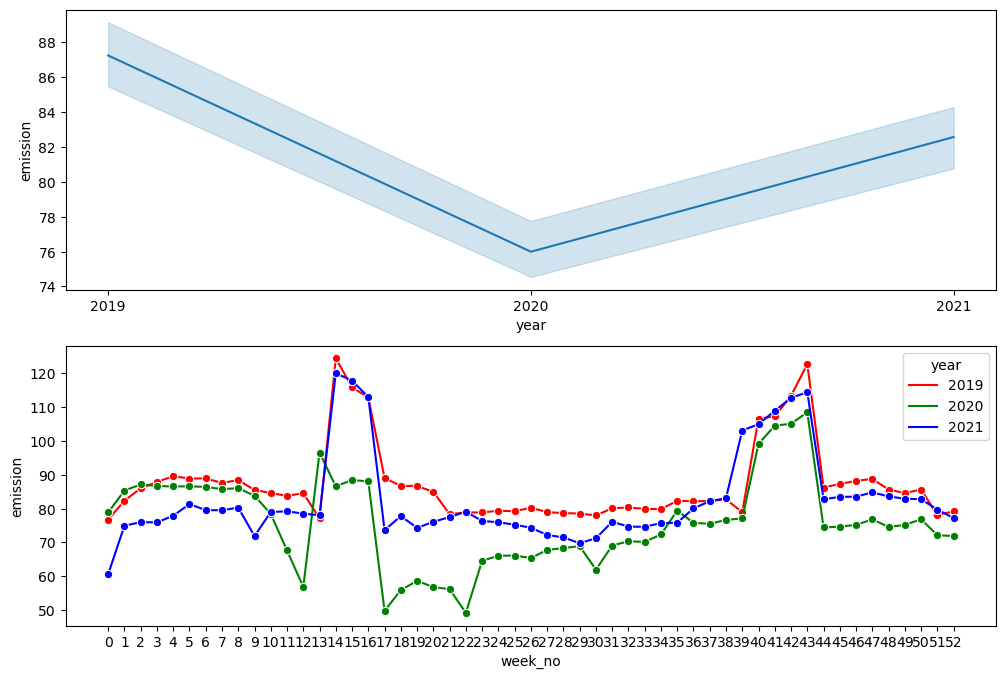

In [20]:
fig, ax = plt.subplots(2,1, figsize=(12,8))
sns.lineplot(x=train['year'].astype('string'), y='emission', data=train, ax=ax[0])
sns.lineplot(x=train['week_no'].astype('string'), y='emission', data=train, hue='year', ax=ax[1], errorbar=None,
            palette=['r','g','b'], marker='o')
plt.show()

COVID impacted hard on the emission during 2020. Emission in 2019 and 2021 have a similar pattern. In 2020 during week 9 - 34, the emissions are significantly lower than the other years. We can try experimenting different exclusion to see which one improves the model.

## e. Label Encoding for location

In [21]:
from sklearn.preprocessing import LabelEncoder
enc = LabelEncoder()

def encode_loc(data):
    """
    args
    data: the data with latitude and longitude to be encoded the same
          as training data
    return
    a dataframe with encoded location
    """
    if 'location' in data.columns.to_list():
        data.drop('location', axis=1, inplace=True)

    df = data.copy()

    if 'location' not in train.columns.to_list() and 'emission' in data.columns.to_list():
        train['location'] = train['latitude'].astype(str) + ' ' + train['longitude'].astype(str)
        
    df['location'] = df['latitude'].astype(str) + ' ' + df['longitude'].astype(str)

    enc.fit(train['location'])
    df['location'] = enc.transform(df['location'])
    
    return df

In [22]:
train_enc = encode_loc(train)
test_enc = encode_loc(test)

# 3.Establishing Base Model
Creating a base model allow us to compare performance of every model we are going to build. The base model will be built using a RandomForestRegressor and uses only 4 features: week_no, year, latitude, and longitude (no standardisation and the gas features). We will train it on 2019 - 2020 and validate it on 2021.

## a. Import libraries

In [23]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import RadiusNeighborsRegressor
from sklearn.metrics import mean_squared_error

## b. Splitting

In [24]:
features = ['week_no', 'location']
target = 'emission'

training_set = train_enc[train_enc.year!=2021]
val_set = train_enc[train_enc.year==2021]

X_train, y_train = training_set[features], training_set[target]
X_val, y_val = val_set[features], val_set[target]

X_train

,week_no,location
ID_LAT_LON_YEAR_WEEK,,
ID_-0.510_29.290_2019_00,0,0
ID_-0.510_29.290_2019_01,1,0
ID_-0.510_29.290_2019_02,2,0
ID_-0.510_29.290_2019_03,3,0
ID_-0.510_29.290_2019_04,4,0
...,...,...
ID_-3.299_30.301_2020_48,48,496
ID_-3.299_30.301_2020_49,49,496
ID_-3.299_30.301_2020_50,50,496


In [25]:
model = RandomForestRegressor(n_estimators=200, random_state=5)
model.fit(X_train, y_train)
y_pred = model.predict(X_val)
rmse = mean_squared_error(y_val, y_pred, squared=False)
print('RMSE:', rmse)

RMSE: 18.898682424566836


In [26]:
y_pred_test = model.predict(test_enc[features])
sub_df = pd.DataFrame(y_pred_test, index=test_enc.index, columns=['emission'])
sub_df

,emission
ID_LAT_LON_YEAR_WEEK,
ID_-0.510_29.290_2022_00,3.781743
ID_-0.510_29.290_2022_01,4.057005
ID_-0.510_29.290_2022_02,4.183491
ID_-0.510_29.290_2022_03,4.233146
ID_-0.510_29.290_2022_04,4.280959
...,...
ID_-3.299_30.301_2022_44,28.618915
ID_-3.299_30.301_2022_45,28.616483
ID_-3.299_30.301_2022_46,29.023062


In [27]:
# sub_df.to_csv('submission.csv')

Score = 36.3

## c. Plotting the prediction

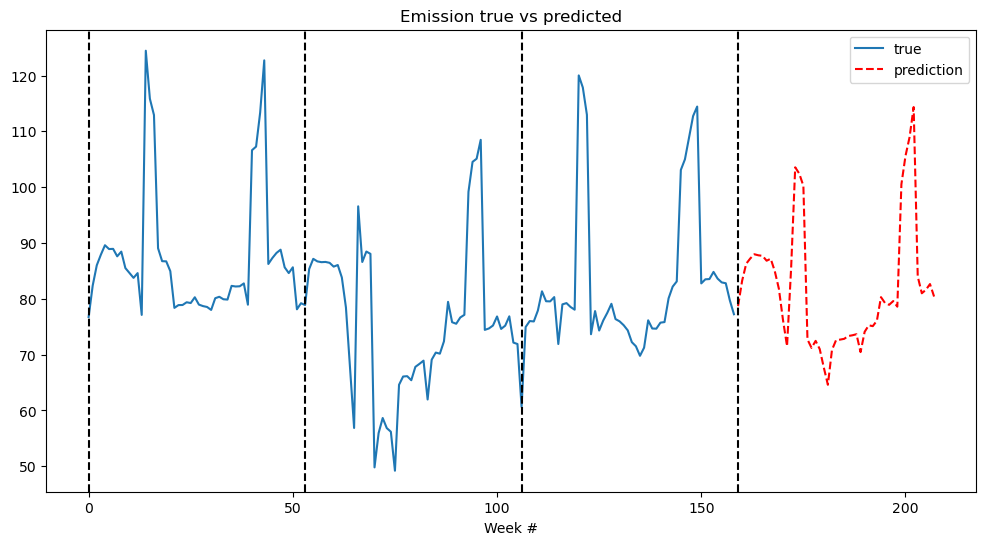

In [28]:
def predict_plot(ypred, train_df, test_df):
    plt.figure(figsize=(12,6))
    test_temp = test_df.copy()
    train_temp = train_df.copy()

    test_temp['emission'] = ypred
    concat_df = pd.concat([train_temp, test_temp])

    tg = train_temp.groupby(['year', 'week_no']).mean()
    tg = tg.set_index(pd.Index(list(range(len(tg)))))
    pg = test_temp.groupby(['year', 'week_no']).mean()
    pg = pg.set_index(pd.Index(list(range(len(tg), len(tg)+len(pg)))))
    
    plt.plot(tg.index, tg.emission, label='true')
    plt.plot(pg.index, pg.emission, label='prediction', color='red', linestyle='--')
    for w_no in range(0, 160, 53):
        plt.axvline(w_no, linestyle='--', color='black')
    plt.legend()
    plt.title('Emission true vs predicted')
    plt.xlabel('Week #')
    plt.show()
    
predict_plot(y_pred_test, train_enc, test_enc)

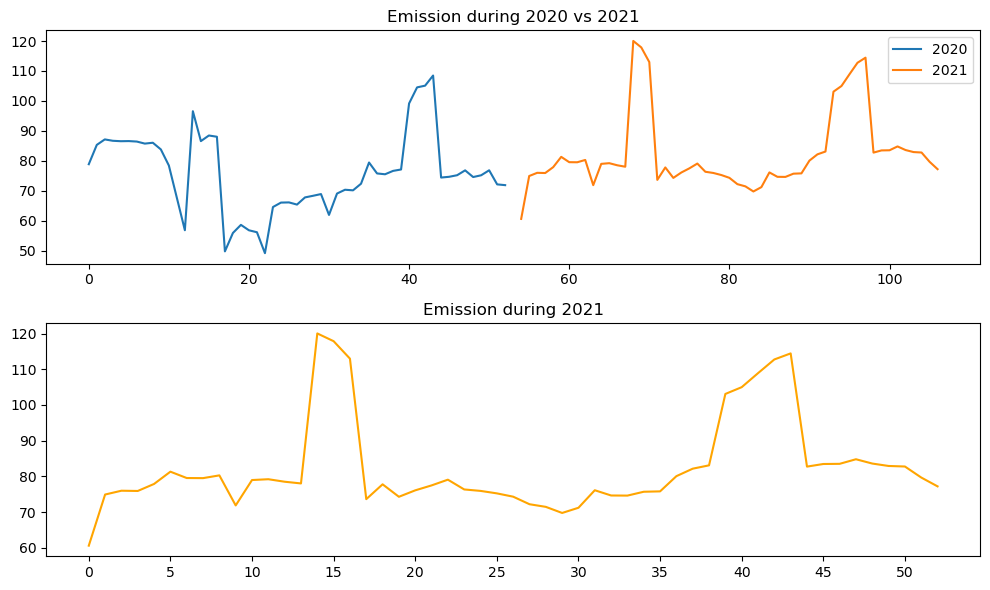

In [29]:
df_20 = train_enc[train_enc.year==2020]
df_21 = train_enc[train_enc.year==2021]

df_20 = df_20.groupby(['year', 'week_no']).mean().droplevel(0)
df_21 = df_21.groupby(['year', 'week_no']).mean()

df_21 = df_21.set_index(pd.Index(list(range(54,54 + len(df_21)))))
fig, ax = plt.subplots(2,1, figsize=(10,6))
ax[0].plot(df_20.index, df_20.emission, label=2020)
ax[0].plot(df_21.index, df_21.emission, label=2021)
ax[0].legend()
ax[0].set_title('Emission during 2020 vs 2021')
ax[1].plot(np.array(df_21.index)-54, df_21.emission, color='orange')
ax[1].xaxis.set_ticks(np.arange(min(df_21.index)-54, max(df_21.index)-53, 5))
ax[1].set_title('Emission during 2021')
fig.tight_layout()
plt.show()

The decreasing trend in 2020 due to COVID were quite low compared to other years as we saw in the EDA. This might influence the model, so next I am going to train the model without COVID influence. 

At this stage we can capture seasonality revolving around week. We want to see if there is seasonality with month or quarter.

In [30]:
train_enc['quarter'] = train_enc['week_no'] // 14 + 1
test_enc['quarter'] = test_enc['week_no'] // 14 + 1
wo_covid = train_enc[(train_enc.year==2019) | (
    ((train_enc.year==2020) & (train_enc.week_no<8) |
     (train_enc.year==2021) & (train_enc.week_no>7))
)]
wo_covid

,latitude,longitude,year,week_no,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,SulphurDioxide_sensor_zenith_angle,...,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle,emission,location,quarter
ID_LAT_LON_YEAR_WEEK,,,,,,,,,,,,,,,,,,,,,
ID_-0.510_29.290_2019_00,-0.510,29.290,2019,0,-0.000108,0.603019,-0.000065,0.255668,-98.593887,50.843559,...,2615.120483,15.568533,0.272292,-12.628986,35.632416,-138.786423,30.752140,3.750994,0,1
ID_-0.510_29.290_2019_01,-0.510,29.290,2019,1,0.000021,0.728214,0.000014,0.130988,16.592861,39.137194,...,3174.572424,8.690601,0.256830,30.359375,39.557633,-145.183930,27.251779,4.025176,0,1
ID_-0.510_29.290_2019_02,-0.510,29.290,2019,2,0.000514,0.748199,0.000385,0.110018,72.795837,52.868816,...,3516.282669,21.103410,0.251101,15.377883,30.401823,-142.519545,26.193296,4.231381,0,1
ID_-0.510_29.290_2019_03,-0.510,29.290,2019,3,NaN,NaN,NaN,NaN,NaN,NaN,...,4180.973322,15.386899,0.262043,-11.293399,24.380357,-132.665828,28.829155,4.305286,0,1
ID_-0.510_29.290_2019_04,-0.510,29.290,2019,4,-0.000079,0.676296,-0.000048,0.121164,4.121269,35.515587,...,3355.710107,8.114694,0.235847,38.532263,37.392979,-141.509805,22.204612,4.347317,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ID_-3.299_30.301_2021_48,-3.299,30.301,2021,48,0.000284,1.195643,0.000340,0.191313,72.820518,55.988022,...,4590.879504,20.245954,0.304797,-35.140368,40.113533,-129.935508,32.095214,29.404171,496,4
ID_-3.299_30.301_2021_49,-3.299,30.301,2021,49,0.000083,1.130868,0.000063,0.177222,-12.856753,19.435339,...,4659.130378,6.104610,0.314015,4.667058,47.528435,-134.252871,30.771469,29.186497,496,4
ID_-3.299_30.301_2021_50,-3.299,30.301,2021,50,NaN,NaN,NaN,NaN,NaN,NaN,...,5222.646823,14.817885,0.288058,-0.340922,35.328098,-134.731723,30.716166,29.131205,496,4


In [31]:
features = ['week_no', 'location', 'quarter']
target = 'emission'

# training_set = wo_covid[wo_covid.year!=2021]
# val_set = wo_covid[wo_covid.year==2021]

X_train, y_train = wo_covid[features], wo_covid[target]
# X_val, y_val = val_set[features], val_set[target]

X_train

,week_no,location,quarter
ID_LAT_LON_YEAR_WEEK,,,
ID_-0.510_29.290_2019_00,0,0,1
ID_-0.510_29.290_2019_01,1,0,1
ID_-0.510_29.290_2019_02,2,0,1
ID_-0.510_29.290_2019_03,3,0,1
ID_-0.510_29.290_2019_04,4,0,1
...,...,...,...
ID_-3.299_30.301_2021_48,48,496,4
ID_-3.299_30.301_2021_49,49,496,4
ID_-3.299_30.301_2021_50,50,496,4


In [32]:
model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=200, random_state=5)

In [33]:
y_pred_test = model.predict(test_enc[features])
sub_df = pd.DataFrame(y_pred_test, index=test_enc.index, columns=['emission'])
sub_df

,emission
ID_LAT_LON_YEAR_WEEK,
ID_-0.510_29.290_2022_00,3.776806
ID_-0.510_29.290_2022_01,4.056199
ID_-0.510_29.290_2022_02,4.192198
ID_-0.510_29.290_2022_03,4.236501
ID_-0.510_29.290_2022_04,4.280491
...,...
ID_-3.299_30.301_2022_44,29.992090
ID_-3.299_30.301_2022_45,30.193782
ID_-3.299_30.301_2022_46,30.418548


In [34]:
# sub_df.to_csv('submission.csv')

Score = 31.25

# 4. PCA

We derived quarter for the covid model. Next, we are going to inspect more useful features that can improve the model performance other than using advanced models.

As the discussion of location dependencies, I am going to do dimensionality reduction on the emissions based on the locations.

In [35]:
pivot_train = train_enc.pivot(index=['location'],
                              columns=['week_no', 'year', 'quarter'],
                              values='emission')
pivot_train

week_no,0,1,2,3,4,5,6,7,8,9,...,43,44,45,46,47,48,49,50,51,52
year,2019,2019,2019,2019,2019,2019,2019,2019,2019,2019,...,2021,2021,2021,2021,2021,2021,2021,2021,2021,2021
quarter,1,1,1,1,1,1,1,1,1,1,...,4,4,4,4,4,4,4,4,4,4
location,,,,,,,,,,,,,,,,,,,,,
0,3.750994,4.025176,4.231381,4.305286,4.347317,4.310819,4.269334,4.251361,4.281937,4.352933,...,4.629182,4.600272,4.652008,4.641428,4.743777,4.736880,4.687898,4.607418,4.470275,4.269510
1,3.857115,4.213432,4.451489,4.553981,4.676066,4.547773,4.560501,4.482812,4.551896,4.516072,...,4.542092,4.601799,4.610928,4.607654,4.632980,4.770357,4.718280,4.683615,4.450044,4.318747
2,0.500023,0.529315,0.554183,0.561553,0.559731,0.564116,0.553346,0.556356,0.556730,0.577506,...,0.639289,0.625299,0.636647,0.634561,0.656226,0.639599,0.633356,0.618269,0.609128,0.575292
3,100.382980,106.375980,110.766335,113.097940,114.985886,117.219720,116.462480,114.035280,113.942320,123.436360,...,133.926060,122.317180,125.746230,125.857475,131.878270,116.865940,116.537730,116.176040,115.053840,110.330900
4,0.076542,0.081001,0.084788,0.085920,0.085650,0.086405,0.084759,0.085190,0.085231,0.088540,...,0.098056,0.095698,0.097470,0.097157,0.100530,0.097723,0.096784,0.094502,0.093149,0.087978
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
492,15.069341,16.217907,16.811665,17.231894,17.642060,17.182430,17.348898,17.046635,17.285320,17.126566,...,15.564887,15.680665,15.678098,15.700193,15.649941,16.179245,16.033224,16.150730,15.336843,15.040095


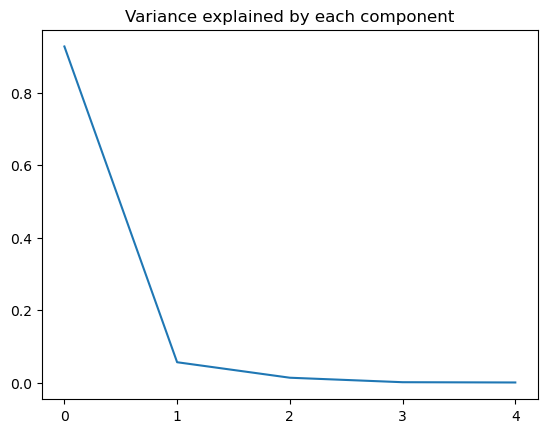

In [36]:
from sklearn.decomposition import PCA

pca = PCA(n_components=5)
pca.fit(pivot_train)
plt.plot(pca.explained_variance_ratio_)
plt.title('Variance explained by each component')
plt.xticks(range(pca.n_components_))
plt.show()

Here I tried to do PCA with 5 components and as can be seen the first component alone explained ~93% variance. We can infer that all locations have linear dependencies of only ~3 locations. 

Next we are going to see seasonal patterns as it suggested using heatmap of the PCA components.

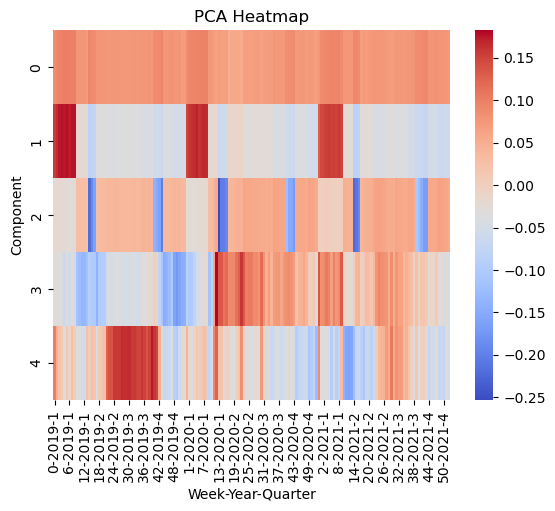

In [37]:
sns.heatmap(pd.DataFrame(pca.components_, columns=pivot_train.columns), cmap='coolwarm')
plt.title('PCA Heatmap')
plt.ylabel('Component')
plt.xlabel('Week-Year-Quarter')
plt.show()

As it have been discussed, there are some interesting patterns here.
- Vector 1 indicates that the first two months always peak.
- Vector 2 indicates that there is a strong difference around May and October.
- Vector 3 indicates the change of emission during COVID in 2020 starting week 8.

In [38]:
top_locations = []
for lat, lon, _ in coords_[-5:]:
    loc = train_enc[(train_enc.latitude==lat) & (train_enc.longitude==lon)]['location'].values
    top_locations.append(loc[0])
top_locations

[135, 43, 136, 293, 357]

In [39]:
# run once
top_em = pivot_train[pivot_train.index.isin(top_locations)]
oth_em = pivot_train[~pivot_train.index.isin(top_locations)]
top_em = top_em.T
top_em = top_em.set_index(pd.Index(list(range(len(top_em)))))
oth_em = oth_em.T
oth_em = oth_em.set_index(pd.Index(list(range(len(oth_em)))))

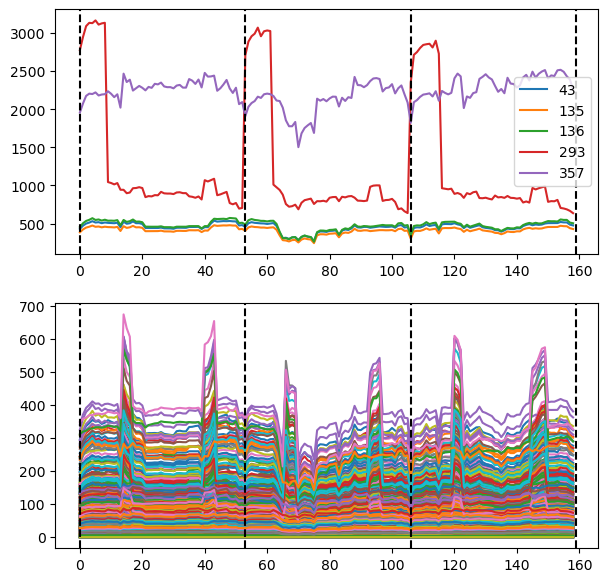

In [40]:
fig, ax = plt.subplots(2,1, figsize=(7,7))

ax[0].plot(top_em.index, top_em.values)
ax[0].legend(top_em.columns)
        
ax[1].plot(oth_em.index, oth_em.values)

for i in range(2):
    for w_no in range(0, 160, 53):
            ax[i].axvline(w_no, linestyle='--', color='black')
plt.show()

Above are the emission plot for each year. We can see that the top two locations have different pattern than the other three. The legend is now only encoded by the label encoder. It might be useful to find out more about these locations.

When compared to the other locations on the bottom plot, there is an obvious pattern that is broadcasted to almost all locations.

In [41]:
coords_[:15] # 15 locations with zero values

array([[-2.898, 29.002,  0.   ],
       [-2.859, 29.041,  0.   ],
       [-2.841, 29.159,  0.   ],
       [-2.817, 29.283,  0.   ],
       [-2.496, 28.504,  0.   ],
       [-1.974, 28.526,  0.   ],
       [-1.839, 28.761,  0.   ],
       [-1.833, 28.467,  0.   ],
       [-1.73 , 28.47 ,  0.   ],
       [-1.712, 28.688,  0.   ],
       [-1.696, 28.304,  0.   ],
       [-1.682, 29.218,  0.   ],
       [-1.532, 28.568,  0.   ],
       [-1.505, 30.995,  0.   ],
       [-1.328, 28.872,  0.   ]])

There are 15 locations with zero mean value of emission.

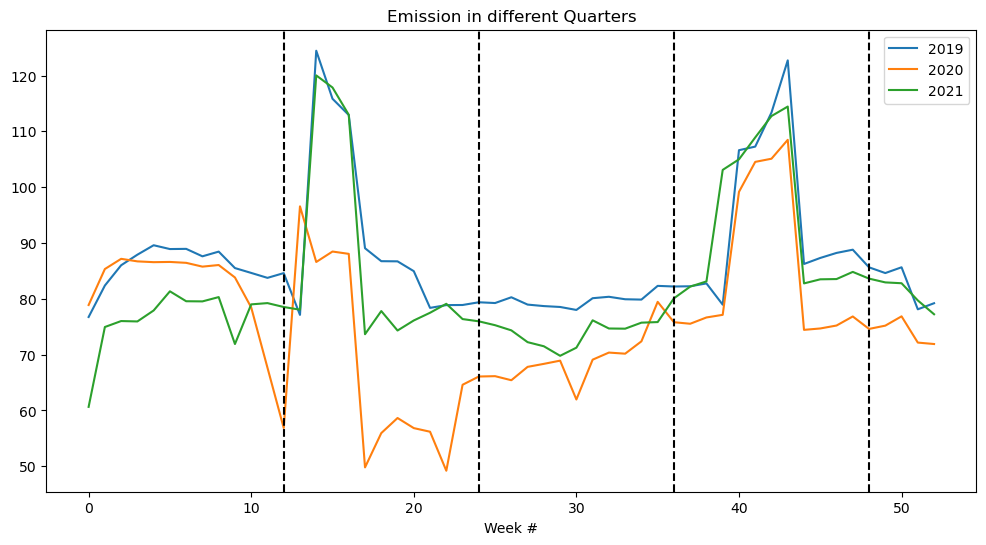

In [42]:
# fig, ax = plt.subplots(2,2, figsize=(12,6))
plt.figure(figsize=(12,6))
# ax = ax.ravel()
for i, year in enumerate(list(range(2019,2022))):
    data = train_enc[train_enc['year']==year]
    data = data.groupby('week_no').mean()
    plt.plot(data.index, data.emission, label=f'{year}')

plt.title('Emission in different Quarters')
plt.xlabel('Week #')
for w_no in range(12, 49, 12):
    plt.axvline(w_no, linestyle='--', color='black')
plt.legend()
# fig.tight_layout()
plt.show()

Maybe it's worth trying to train on different quarters and excluding some weeks. For instance, we could exclude the end of Q1 2020, Q2 2020, Q3 2020. I am not going to train on week 49 onwards because it does not appear in the test set.

In [43]:
the_map = folium.Map(prefer_canvas=True)
comb_coords = list(coords_[:15]) + list(coords_[-2:]) # these are the locations with zero values and highest values
HeatMap(comb_coords).add_to(the_map)
the_map.fit_bounds(the_map.get_bounds())
the_map

Strangely enough the missing values indicated above are not located exactly in Rwanda with some in DR Congo (west from Rwanda), in Burundi (below), and in Tanzania (east). The two highest emissions are located within Rwanda. Upon further research, the first place is in Nyirahindwe, second place is in near Karongi (recorded near Lac Kivu).

I am going to try encoding this location in hope for correlation with the emission. I am going to use geoencoder library and it is important to note that it sends request to get the country from coordinates, so it performs slow when running against a lot of coordinates. I am going to filter locations that are within Rwanda by defining upper and lower boundaries. This boundaries will be an area that is square-shaped. 

# 5. Extracting Countries

In [44]:
the_map = folium.Map(prefer_canvas=True)
ini_coords = np.array([-1.9437057, 29.8805778])
bounds1 = np.concatenate(( 
                         np.reshape([ini_coords[0] + 0.54, ini_coords[1] + 0.9], (1,-2)), # These are the values that are manually tuned
                         np.reshape([ini_coords[0] - 0.43, ini_coords[1] - 0.45], (1,-2)) # to get the lower and upper boundaries
                       ))
bounds2 = np.concatenate(( 
                         np.reshape([ini_coords[0] + 0.35, ini_coords[1] + 0.07], (1,-2)), # These are the values that are manually tuned
                         np.reshape([ini_coords[0] - 0.7, ini_coords[1] - 0.62], (1,-2)) # to get the lower and upper boundaries
                       ))
folium.Marker(location=ini_coords,).add_to(the_map)
folium.Rectangle(bounds1).add_to(the_map)
folium.Rectangle(bounds2).add_to(the_map)
the_map.fit_bounds(the_map.get_bounds())
the_map

In [45]:
# perform check to run the query in next cell faster
# check if the area only contains locations from Rwanda
ub1 = bounds1[0]
lb1 = bounds1[1]
ub2 = bounds2[0]
lb2 = bounds2[1]
temp1 = []
temp2 = []

for i in coords_[:, :2]:
    if i[0]>lb1[0] and i[1]>lb1[1] and i[0]<ub1[0] and i[1]<ub1[1]:
        temp1.append(list(i))
        
for i in coords_[:, :2]:
    if i[0]>lb2[0] and i[1]>lb2[1] and i[0]<ub2[0] and i[1]<ub2[1]:
        temp2.append(list(i))

# temp1 = [', '.join(str(k) for k in i) for i in temp1]
# temp2 = [', '.join(str(k) for k in i) for i in temp2]
flag = True
# run only once
# for i in temp1:
#     if country_dict[i] != 'Rwanda': # country_dict already defined in next cell
#         print('not equal')
#         flag=False
#         break
# for i in temp2:
#     if country_dict[i] != 'Rwanda': # country_dict already defined in next cell
#         print('not equal')
#         flag=False
#         break
coords_Rwanda = temp1+temp2
coords_Rwanda = [', '.join(str(k) for k in i) for i in coords_Rwanda]
coords_Rwanda = list(set(coords_Rwanda))
if flag:
    print(f'There are {len(coords_Rwanda)} locations within the areas')

There are 120 locations within the areas


In [46]:
coords_q = []
for i in [', '.join(str(k) for k in a) for a in coords_[:, :2]]:
    if i not in coords_Rwanda:
        coords_q.append(i)
print(len(coords_q))

377


I have reduced the queries from 497 - 120 = 377 locations that need to be queried. Only run the next cells if you want to know how the API extracts country names given coordinates. I have created the test and train csv files that include country names correctly to save time.

In [47]:
# # this takes a while to run
# from geopy.geocoders import Nominatim

# from datetime import datetime

# time = datetime.now()
# geoloc = Nominatim(user_agent="myApi")
# # coords_str = [str(lat)+', '+str(lon) for lat, lon in coords_[:, :2]]
# country_dict = dict.fromkeys(coords_q)

# for coord in coords_q:
#     country = geoloc.reverse(coord, exactly_one=True).raw['address']['country']
#     country_dict[coord] = country
# print(f'Queries executed in: {str(datetime.now() - time)[-12:-7]}')

In [48]:
# counter = 0
# for i in country_dict:
#     if country_dict[i]=='Rwanda':
#         counter += 1
# print(f'There are {len(coords_Rwanda)+counter} locations in Rwanda ({(len(coords_Rwanda)+counter)*100/497:.2f}%)')
# print(f'There are {len(coords_q)-counter} locations not in Rwanda ({(len(coords_q)-counter)*100/497:.2f}%)')

Most of the locations where emission is recorded are not in Rwanda. 32% were recorded in Rwanda and 68% were recorded outside Rwanda.

In [49]:
# # fill with Rwanda
# rwanda_dict = dict.fromkeys(coords_Rwanda)
# for i in rwanda_dict:
#     rwanda_dict[i] = 'Rwanda'
# comb_dict = country_dict | rwanda_dict
# len(comb_dict)

In [50]:
# train_enc['country'] = train_enc['latitude'].astype(str) + ', ' + train_enc['longitude'].astype(str)
# train_enc['country'] = train_enc['country'].map(comb_dict)
# train_enc[train_enc['country'].isna()]

In [51]:
# print('Countries in train data:', list(set(train_enc.country)))
# train_enc.country.value_counts()

There are five countries in the train data, they are the neighbouring countries of Rwanda. Most of the data recorded are still from Rwanda. We are going to inspect whether there is any correlation with emission. 

In [52]:
# # check countries exist on test set
# test_enc['country'] = test_enc['latitude'].astype(str) + ', ' + test_enc['longitude'].astype(str)
# test_enc['country'] = test_enc['country'].map(comb_dict)
# test_enc[test_enc['country'].isna()]

I am going to save the data that includes country names to save time in querying.

In [53]:
# train_enc.to_csv('train_proc')
# test_enc.to_csv('test_proc')

In [54]:
train_enc = pd.read_csv('/kaggle/input/train-test-processed/train_proc.csv', 
                        index_col='ID_LAT_LON_YEAR_WEEK')
test_enc = pd.read_csv('/kaggle/input/train-test-processed/test_proc.csv', 
                       index_col='ID_LAT_LON_YEAR_WEEK')

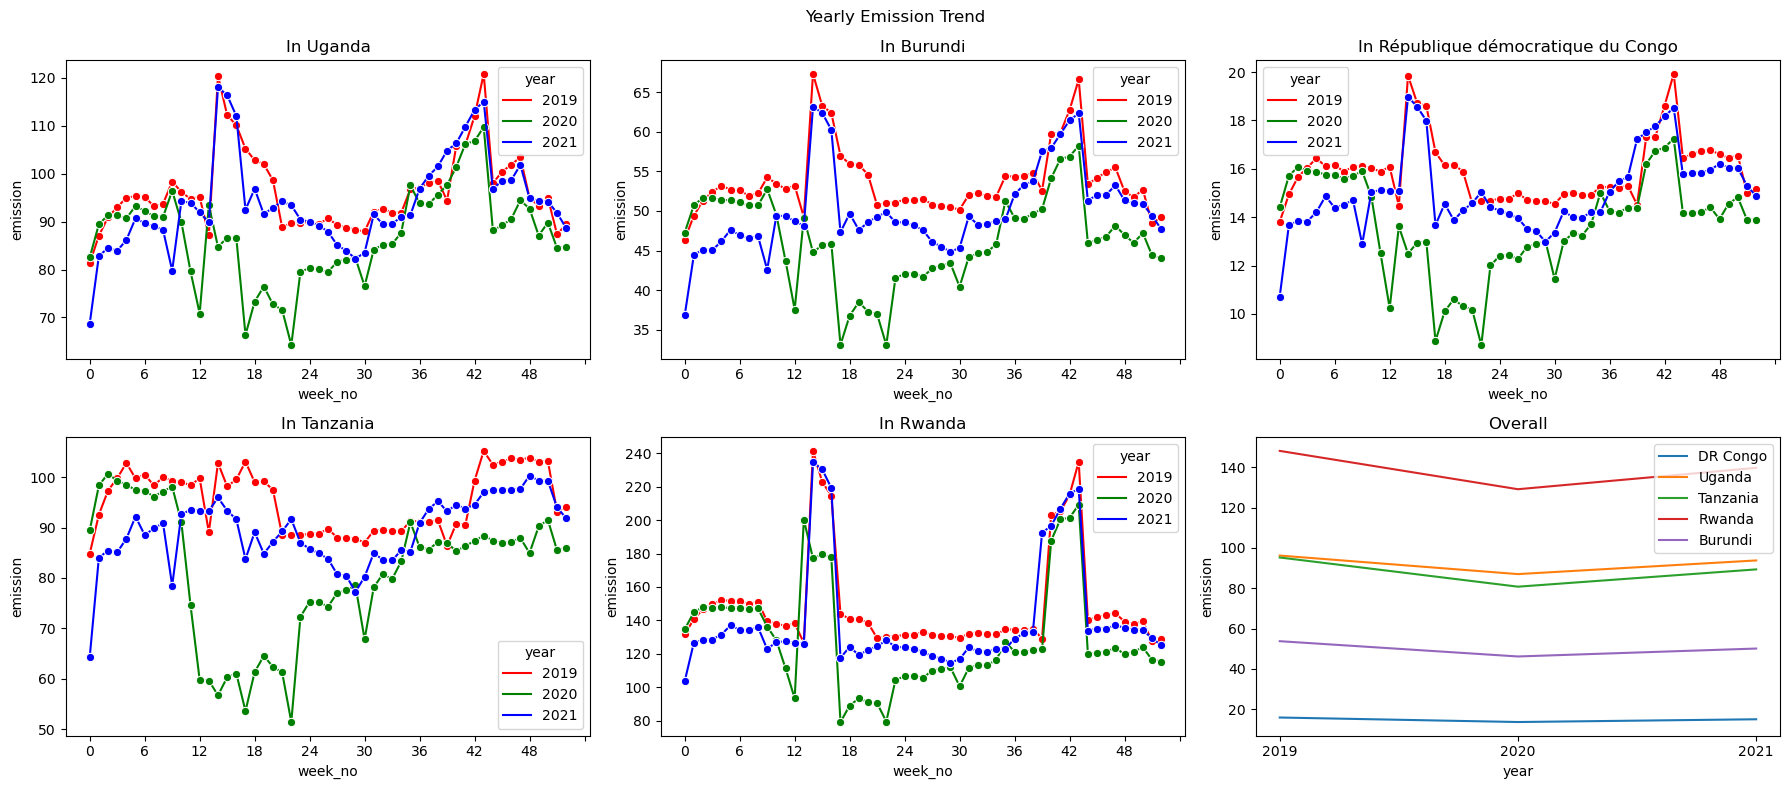

In [55]:
from matplotlib.ticker import MaxNLocator

fig, ax = plt.subplots(2,3, figsize=(18,8))
ax = ax.ravel()
plt.suptitle('Yearly Emission Trend')

for i, country in enumerate(list(set(train_enc.country))):
    data = train_enc[train_enc['country'] == country]
    sns.lineplot(data=data, x=data['week_no'].astype(str), 
                 y='emission', hue='year', marker='o', errorbar=None, ax=ax[i], palette=['r','g','b'])
    ax[i].set_title(f'In {country}')
    ax[i].xaxis.set_major_locator(MaxNLocator(10))
    
sns.lineplot(data=train_enc, x=train_enc['year'].astype(str), y='emission', hue='country', errorbar=None, ax=ax[-1])
ax[-1].set_title('Overall')
ax[-1].legend(['DR Congo', 'Uganda', 'Tanzania', 'Rwanda', 'Burundi'])

fig.tight_layout()
plt.show()

Insights:
- Overall, seasonality pattern is similar across all countries except in Tanzania where it has different pattern.
- DR Congo has the lowest emission followed by Burundi. Rwanda has the highest emission (might be due to more data/bias).
- Only in Rwanda that emission peaks around week 13 during 2020. Other countries have lower emission.

In [56]:
print('Countries in train data:', list(set(test_enc.country)))
test_enc.country.value_counts()

Countries in train data: ['Uganda', 'Burundi', 'République démocratique du Congo', 'Tanzania', 'Rwanda']


Rwanda                              7791
République démocratique du Congo    6027
Tanzania                            3969
Uganda                              3381
Burundi                             3185
Name: country, dtype: int64

In [57]:
enc.fit(train_enc['country'])
train_enc['country'] = enc.transform(train_enc['country'])
test_enc['country'] = enc.transform(test_enc['country'])
train_enc['country']

ID_LAT_LON_YEAR_WEEK
ID_-0.510_29.290_2019_00    2
ID_-0.510_29.290_2019_01    2
ID_-0.510_29.290_2019_02    2
ID_-0.510_29.290_2019_03    2
ID_-0.510_29.290_2019_04    2
                           ..
ID_-3.299_30.301_2021_48    0
ID_-3.299_30.301_2021_49    0
ID_-3.299_30.301_2021_50    0
ID_-3.299_30.301_2021_51    0
ID_-3.299_30.301_2021_52    0
Name: country, Length: 79023, dtype: int64

In [58]:
# dropping columns with high missing values
def remove_null_cols(data):
    """
    Remove columns with highest missing values (based on earlier check)
    args
    data: the data for columns to be removed
    return
    copy of data with columns removed
    """
    df = data.copy()
    cols_drop1 = null_df_test.sort_values('Total', ascending=False).index.to_list()[:7]
    cols_drop2 = null_df_train.sort_values('Total', ascending=False).index.to_list()[:7]
    assert cols_drop1 == cols_drop2, "Features are not identical" # check if we have the same features name
    df.drop(cols_drop1, axis=1, inplace=True)
    
    return df

train_rem = remove_null_cols(train_enc)
test_rem = remove_null_cols(test_enc)

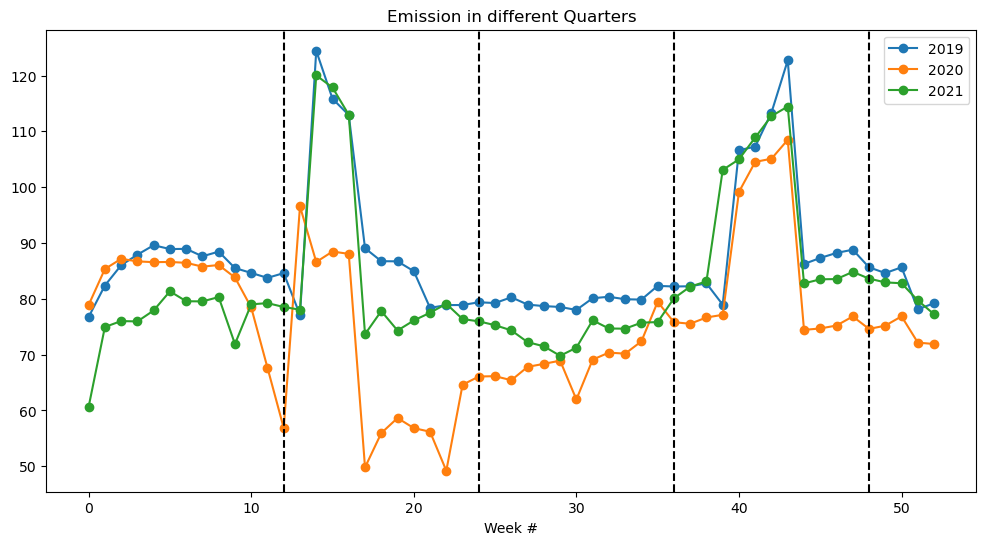

In [59]:
plt.figure(figsize=(12,6))
for i, year in enumerate(list(range(2019,2022))):
    data = train_enc[train_enc['year']==year]
    data = data.groupby('week_no').mean()
    plt.plot(data.index, data.emission, label=f'{year}', marker='o')

plt.title('Emission in different Quarters')
plt.xlabel('Week #')
for w_no in range(12, 49, 12):
    plt.axvline(w_no, linestyle='--', color='black')
plt.legend()
# fig.tight_layout()
plt.show()

# 6. Handling COVID impact

I am going to try build a model to modify the 2020 emission data to handle the low emissions. The COVID range influences the emission values on subsequent years (2021 - 2022). Building a model to predict 2020 emission values might help in smoothing the outliers. The hope is to reduce outliers and improve rmse on 2021 data so that we can extrapolate to 2022.

In [60]:
# removing emission values that were in COVID range
train_imp = train_enc.copy(deep=True)
train_imp.loc[(
    (train_imp.year==2020) & (train_imp.week_no>9)
    & (train_imp.year==2020) & (train_imp.week_no<27)
          ), 'emission'] = None

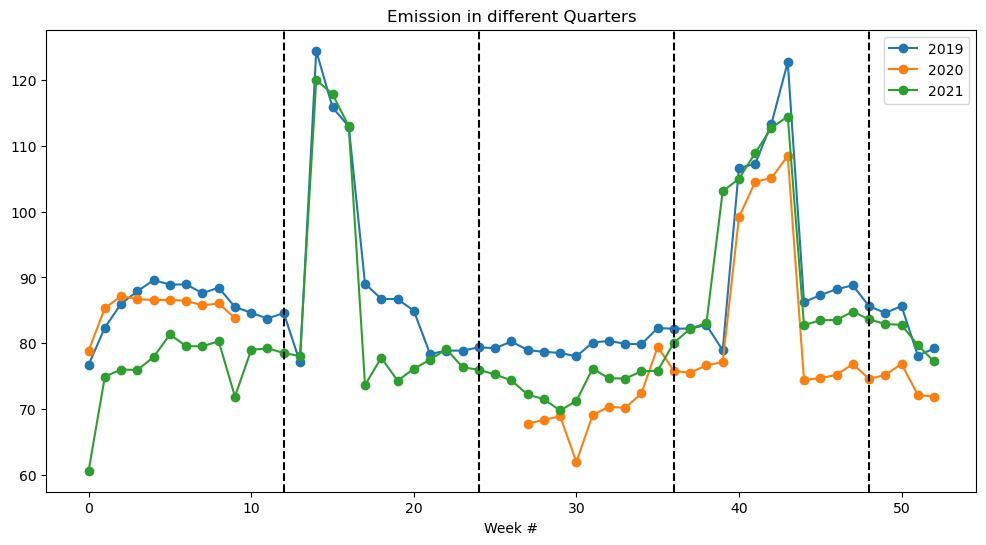

In [61]:
# t_2020 = train_imp.loc[train_imp.year==2020].groupby('week_no').mean()
plt.figure(figsize=(12,6))
for i, year in enumerate(list(range(2019,2022))):
    data = train_imp[train_imp['year']==year]
    data = data.groupby('week_no').mean()
    plt.plot(data.index, data.emission, label=f'{year}', marker='o')

plt.title('Emission in different Quarters')
plt.xlabel('Week #')
for w_no in range(12, 49, 12):
    plt.axvline(w_no, linestyle='--', color='black')
plt.legend()
# fig.tight_layout()
plt.show()


## a. Modelling our COVID data

In [62]:
def preproc(data):
    df = data.copy(deep=True)
    df = df[df['week_no']<49]
    
    return df

In [63]:
train_drop = preproc(train_imp).dropna(subset='emission')

features = ['week_no', 'location', 'country', 'quarter']
target = 'emission'

train_d = train_drop.loc[(train_drop.year==2019) | 
                       ((train_drop.year==2020) & (train_drop.week_no<10))]
X_train = train_d[features]
y_train = train_d[target]

val_d = train_drop.loc[(train_drop.year==2021) | 
                       ((train_drop.year==2020) & (train_drop.week_no>26))]

# week 40 2020 onwards
X_val = val_d[features]
y_val = val_d[target]
# only 2020
val_d20 = train_drop.loc[train_drop.year==2020]
X_val20 = val_d20[features]
y_val20 = val_d20[target]
# only 2021
val_d21 = train_drop.loc[train_drop.year==2021]
X_val21 = val_d21[features]
y_val21 = val_d21[target]

X_val

,week_no,location,country,quarter
ID_LAT_LON_YEAR_WEEK,,,,
ID_-0.510_29.290_2020_27,27,0,2,2
ID_-0.510_29.290_2020_28,28,0,2,3
ID_-0.510_29.290_2020_29,29,0,2,3
ID_-0.510_29.290_2020_30,30,0,2,3
ID_-0.510_29.290_2020_31,31,0,2,3
...,...,...,...,...
ID_-3.299_30.301_2021_44,44,496,0,4
ID_-3.299_30.301_2021_45,45,496,0,4
ID_-3.299_30.301_2021_46,46,496,0,4


In [64]:
model = RandomForestRegressor(n_estimators=200, random_state=77)
model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=200, random_state=77)

In [65]:
row_values = ['Week 40 (2020) onwards', '2021', '2020']
colnames = ['RMSE', 'Val Data']

def make_scoresdf(y_preds, row_values=row_values, colnames=colnames):
    return pd.DataFrame(zip(y_preds, row_values), columns=colnames)

In [66]:
# prediction on week 40 onwards
y_pred40 = model.predict(X_val)
y_pred21 = model.predict(X_val21)
y_pred20 = model.predict(X_val20)
rmse_40 = mean_squared_error(y_val, y_pred40, squared=False)
rmse_21 = mean_squared_error(y_val21, y_pred21, squared=False)
rmse_20 = mean_squared_error(y_val20, y_pred20, squared=False)
make_scoresdf([rmse_40, rmse_21, rmse_20], row_values=row_values, colnames=colnames)

,RMSE,Val Data
0,19.050604,Week 40 (2020) onwards
1,18.983325,2021
2,16.286795,2020


In [67]:
train_pred = train_imp.loc[(train_imp.year==2020) & train_imp.emission.isnull(), features]
em_2020 = model.predict(train_pred)

In [68]:
train_pred = train_imp.copy(deep=True)
train_pred.loc[(train_pred.year==2020) & train_pred.emission.isnull(), 'emission'] = em_2020

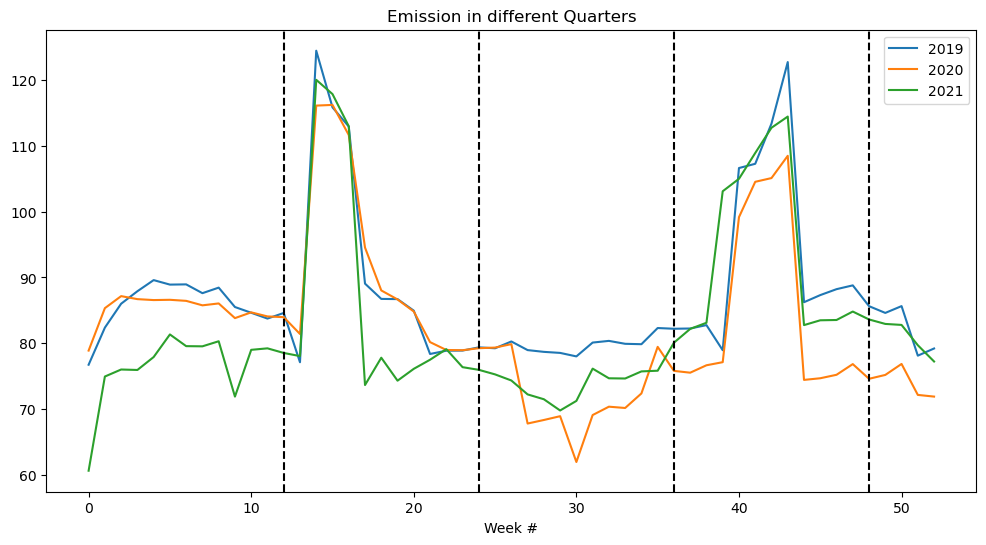

In [69]:
plt.figure(figsize=(12,6))
for i, year in enumerate(list(range(2019,2022))):
    data = train_pred[train_pred['year']==year]
    data = data.groupby('week_no').mean()
    plt.plot(data.index, data.emission, label=f'{year}')

plt.title('Emission in different Quarters')
plt.xlabel('Week #')
for w_no in range(12, 49, 12):
    plt.axvline(w_no, linestyle='--', color='black')
plt.legend()
# fig.tight_layout()
plt.show()

Now the 2020 emission values have been scaled similarly to 2019 values. This might or might not be a good thing for our 2022 predictions. Nevertheless, I am going to experiment on using this constructed COVID emissions. 

We do not know exactly what the trend is because we only have three years of data and even one of the year 2020 is not beneficial. So we can't extrapolate growth/decline to 2022. We only can validate on 2021 data and train on 2019-2020. My intuition is to train on 2019-2021 and have no validation at all. So, we are just testing against the public LB.

Next I am going to use a windowing technique which utilises emission values as both features and target.

## b. Windowing data using mean

This actually might not be a good case because if we want to predict 2020 data in reality we need a lot more data than just 2019. By windowing the dataset we want to separate the emissions by quarter (because we have weekly data). The problem is we do not only have one value per time series, we have several values which consist of each of the 497 locations. So it's hard to use this method because it does not works well with this kind of scenario. 

What we can do however is to averaged it by location yearly to get the weights of each location. So when we predict the mean of weekly emissions by location we can times it against the mean of each location. I am going to call this mean values weights per location. For instance, when location `0` has weight of 0.05, even if the mean emission value is particularly high in a specified week let's say 78, it will be scaled down to ensure the emission value is appropriate to the location.

I am going to use a window size of a month so 4 (because of weekly data). Training it on 2019-2020 (until week 8) and validate it on 2021. Windowing data uses previous n values to predict the next week value so I am going to use RNN and LSTM to utilise the dependencies. We are not going to use the location features and rely on weights to convert it.

In [70]:
# get mean emission by location in 2019
avg_19 = (train_imp.loc[train_imp.year==2019].groupby('location').emission.mean() 
        / train_imp.loc[train_imp.year==2019].emission.mean())
avg_19

location
0      0.050430
1      0.050290
2      0.006875
3      1.366113
4      0.001053
         ...   
492    0.189946
493    0.001466
494    0.538333
495    0.509107
496    0.337820
Name: emission, Length: 497, dtype: float64

In [71]:
def make_prediction(avg_em_year, y_pred):
    pred = np.zeros((497,49))
    for i in range(497):
        pred[i:, :] = avg_em_year.values[i] * y_pred
    return pred

In [72]:
import tensorflow as tf

def windowed_dataset(y, window_size=4, batch_size=5, shuffle_buffer=10):
    """Generates dataset windows

    Args:
      y (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """
  
    # Generate a TF Dataset from the X, y values
    dataset = tf.data.Dataset.from_tensor_slices(y)
    
    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    
    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    
    # Create tuples with features and labels 
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    
    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    return dataset

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [73]:
def plot_metric(history, metric_name1, metric_name2=None, epoch_start=0):
    plt.figure(figsize=(10, 6))
    # Get metric name
    metric1 = history.history[metric_name1]
    
    # Get number of epochs
    epochs=range(epoch_start, len(metric1)) 
    
    plt.plot(epochs, metric1[epoch_start:], label=metric_name1, color='#1D5D9B')
    if metric_name2:
        metric2 = history.history[metric_name2]
        plt.plot(epochs, metric2[epoch_start:], label=metric_name2, color='#0D1282')
    plt.legend()
    plt.show()

In [74]:
window_size = 4
group_data = train_imp.dropna(subset='emission').groupby(['year','week_no']).emission.mean()

train_set = group_data.loc[group_data.index.get_level_values(0)<=2020].values[:10]
train_set = windowed_dataset(train_set, window_size, 2)
val_set = group_data.loc[group_data.index.get_level_values(0)>=2020].values[10:]
val_set = windowed_dataset(val_set, window_size, 2)

# only 2020
val_set20 = group_data.loc[group_data.index.get_level_values(0)==2020].values
val_set20 = windowed_dataset(val_set20, window_size, 2)

# only 2021
val_set21 = group_data.loc[group_data.index.get_level_values(0)==2021].values
val_set21 = windowed_dataset(val_set21, window_size, 2)

for x, y in train_set:
    print('First batch of train_set')
    print(x.numpy())
    print(y.numpy())
    break
print()
for x, y in val_set:
    print('First batch of val_set')
    print(x.numpy())
    print(y.numpy())
    break   

First batch of train_set
[[86.00882337 87.90396445 89.59509462 88.91222054]
 [87.90396445 89.59509462 88.91222054 88.94622502]]
[88.94622502 87.61086128]

First batch of val_set
[[70.36600353 70.16939657 72.37998299 79.45513965]
 [72.37998299 79.45513965 75.80565633 75.53056309]]
[75.80565633 76.65711043]


Our last batch of train set and val set have 4 samples instead of 5 due to slicing of 2019 - week 9 of 2020 in train set and week 40 of 2020 - 2021 (59 weeks total for both).

## c. RNN Model

In [75]:
import tensorflow.keras.layers as tfl

# rnn_model = tf.keras.models.Sequential([
#     tfl.Conv1D(128, 1, 1, padding='causal', activation='relu', input_shape=(window_size,1)),
#     tfl.MaxPooling1D(),
# #     tfl.Conv1D(128, 1, 1, padding='causal', activation='relu'),
# #     tfl.MaxPooling1D(),
# #     tfl.Flatten(),
# #     tfl.Dropout(0.2),
#     tfl.SimpleRNN(128, return_sequences=True),
#     tfl.SimpleRNN(128),
#     tfl.Dense(64, activation='relu'),
#     tfl.Dense(10, activation='relu'),
#     tfl.Dense(1)
# ])
# rnn_model.summary()

In [76]:
# # Get initial weights
# init_weights = rnn_model.get_weights()

# # Set the learning rate scheduler
# lr_schedule = tf.keras.callbacks.LearningRateScheduler(
#     lambda epoch: 1e-7 * 10**(epoch / 20))

# # Initialize the optimizer
# optimizer = tf.keras.optimizers.Adam()

# # Set the training parameters
# rnn_model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=optimizer)

# # Train the model
# history = rnn_model.fit(train_set, epochs=100, callbacks=[lr_schedule])

In [77]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

def plot_learning_rate(lrs, history):
    # Set the figure size
    plt.figure(figsize=(10, 6))

    # Set the grid
    plt.grid(True)

    # Plot the loss in log scale
    plt.semilogx(lrs, history.history["loss"])

    # Increase the tickmarks size
    plt.tick_params('both', length=10, width=1, which='both')
    plt.title('Loss by learning rate')

    # Set the plot boundaries
    plt.axis([1e-8, 1e-3, 0, 200])
    plt.show()
# plot_learning_rate(lrs, history)

In [78]:
# # Reset states generated by Keras
# tf.keras.backend.clear_session()

# # Reset the weights
# rnn_model.set_weights(init_weights)

In [79]:
# early_stop = tf.keras.callbacks.EarlyStopping(
#                     monitor='val_root_mean_squared_error',
#                     min_delta=0,
#                     patience=75,
#                     verbose=1,
#                     mode='min',
#                     baseline=13,
#                     restore_best_weights=True,
#                 )
# # Set the learning rate
# initial_learning_rate = 5e-4

# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate,
#     decay_steps=50,
#     decay_rate=0.96,
#     staircase=True)

In [80]:
# # Set the optimizer 
# optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

# # Set the training parameters
# rnn_model.compile(loss=tf.keras.losses.MeanSquaredError(),
#                   optimizer=optimizer,
#                   metrics=[tf.keras.metrics.RootMeanSquaredError()]
#                  )

In [81]:
# # Train the model
# history = rnn_model.fit(train_set, epochs=500, callbacks=[early_stop], validation_data=val_set21)

In [82]:
# plot_metric(history, 'root_mean_squared_error', 'val_root_mean_squared_error', 8)

In [83]:
# _, rnn_rmse40 = rnn_model.evaluate(val_set)
# _, rnn_rmse21 = rnn_model.evaluate(val_set21)
# _, rnn_rmse20 = rnn_model.evaluate(val_set20)
# make_scoresdf([rnn_rmse40, rnn_rmse21, rnn_rmse20], row_values=row_values, colnames=colnames)

Our RNN model attain RMSE score around ~13 on validation set. Let's try with LSTM.

## d. LSTM Model

In [84]:
# lstm_model = tf.keras.models.Sequential([
#     tfl.Conv1D(64, 3, 1, padding='causal', activation='relu', input_shape=(window_size,1)),
#     tfl.MaxPooling1D(),
# #     tfl.Conv1D(128, 3, 1, padding='causal', activation='relu'),
# #     tfl.MaxPooling1D(),
# #     tfl.Dropout(0.2),
#     tfl.Bidirectional(tfl.LSTM(64, return_sequences=True)),
#     tfl.Bidirectional(tfl.LSTM(64)),
#     tfl.Dense(32, activation='relu'),
#     tfl.Dense(16, activation='relu'),
#     tfl.Dense(1)
# ])
# lstm_model.summary()

In [85]:
# # Get initial weights
# init_weights = lstm_model.get_weights()

# # Set the learning rate scheduler
# lr_schedule = tf.keras.callbacks.LearningRateScheduler(
#     lambda epoch: 1e-6 * 10**(epoch / 20))

# # Initialize the optimizer
# optimizer = tf.keras.optimizers.Adam()

# # Set the training parameters
# lstm_model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=optimizer)

# # Train the model
# history = lstm_model.fit(train_set, epochs=100, callbacks=[lr_schedule])

In [86]:
# plot_learning_rate(lrs, history)

In [87]:
# # Reset states generated by Keras
# tf.keras.backend.clear_session()

# # Reset the weights
# lstm_model.set_weights(init_weights)

In [88]:
# initial_learning_rate = 5e-5

# early_stop = tf.keras.callbacks.EarlyStopping(
#                     monitor='val_root_mean_squared_error',
#                     min_delta=0,
#                     patience=75,
#                     verbose=1,
#                     mode='min',
#                     baseline=11,
#                     restore_best_weights=True,
#                 )

# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate,
#     decay_steps=50,
#     decay_rate=0.96,
#     staircase=True)

In [89]:
# # Set the optimizer 
# optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

# # Set the training parameters
# lstm_model.compile(loss=tf.keras.losses.MeanSquaredError(),
#                    optimizer=optimizer,
#                    metrics=[tf.keras.metrics.RootMeanSquaredError()]
#                   )

In [90]:
# # Train the model
# history = lstm_model.fit(train_set, epochs=500, callbacks=[early_stop], validation_data=val_set21)

In [91]:
# plot_metric(history, 'root_mean_squared_error', 'val_root_mean_squared_error')

In [92]:
# _, lstm_rmse40 = lstm_model.evaluate(val_set)
# _, lstm_rmse21 = lstm_model.evaluate(val_set21)
# _, lstm_rmse20 = lstm_model.evaluate(val_set20)
# make_scoresdf([lstm_rmse40, lstm_rmse21, lstm_rmse20], row_values=row_values, colnames=colnames)

With LSTM it achieves ~12 RMSE score on validation set.

In [93]:
def predict_data(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    # Get predictions on the entire dataset
    forecast = model.predict(dataset)
    
    return forecast

In [94]:
# temp_vals = group_data_.loc[group_data_.index.get_level_values(0)>=2020].values[49-window_size:-1]
# pred_vals = predict_data(lstm_model, temp_vals, window_size, 2).squeeze()
# pred_vals

In [95]:
# plt.plot(range(49), pred_vals, color='r')
# plt.plot(range(49), group_data_.loc[group_data_.index.get_level_values(0)==2019].values, color='b')

The windowing technique cannot fit the data well and I believe that this is due to lack of data with just one year. Neural Networks work well with a lot of data so I might try it to fit on the whole training data for our final prediction after imputing the 2020 COVID emission values with prediction.

# 7. Model Experimenting

## a. Preprocessing
Let's remove the week number that does not appear in the test set. I'm also going to try different splits to remove the COVID influence for prediction in 2021 (validation).

The test set only consist of 49 week numbers from 0 - 48, while the train set has 54 week numbers from 0-53. So let's only include week 0 - 48.

In [96]:
train_preproc = preproc(train_pred)
test_preproc = preproc(test_enc)

In [97]:
# train_wo_covid = train_preproc[(train_preproc.year==2019) | 
#                              ((train_preproc.year==2020) & (train_preproc.week_no<8))
#                              | ((train_preproc.year==2020) & (train_preproc.week_no>40))
#                              | (train_preproc.year==2021)
#                               ]

## b. Splitting

In [98]:
features = ['week_no', 'location', 'country']
target = 'emission'

training_set = train_preproc[train_preproc.year!=2021]
val_set = train_preproc[train_preproc.year==2021]

X_train, y_train = training_set[features], training_set[target]
X_val, y_val = val_set[features], val_set[target]

X_train

,week_no,location,country
ID_LAT_LON_YEAR_WEEK,,,
ID_-0.510_29.290_2019_00,0,0,2
ID_-0.510_29.290_2019_01,1,0,2
ID_-0.510_29.290_2019_02,2,0,2
ID_-0.510_29.290_2019_03,3,0,2
ID_-0.510_29.290_2019_04,4,0,2
...,...,...,...
ID_-3.299_30.301_2020_44,44,496,0
ID_-3.299_30.301_2020_45,45,496,0
ID_-3.299_30.301_2020_46,46,496,0


## c. Model

In [99]:
from xgboost import XGBRegressor

import optuna

In [100]:
def objective(trial):
    # Define the hyperparameter search space
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1, log=True),
        'max_depth':trial.suggest_int('max_depth', 4, 10),
        'gamma': trial.suggest_float('gamma', 1e-4, 0.5, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-9, 10, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-7, 10, log=True),
    }
    model = XGBRegressor(**params, random_state=77, objective='reg:squarederror',
                         n_estimators=2000, 
                         early_stopping_rounds=100,
                         eval_metric='rmse')
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)])
    y_hat = model.predict(X_val)
    rmse = mean_squared_error(y_val, y_hat, squared=False)
    return rmse

In [101]:
# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=10)
# best_params = study.best_params
# best_score = study.best_value
# print('The best parameters are:', best_params)
# print('The best RMSE is:', best_score)

In [102]:
# print('The best params are:', best_params)
# print('The best RMSE is:', best_score)

In [103]:
# xgb_model = XGBRegressor(**best_params, random_state=77, objective='reg:squarederror',
#                          n_estimators=2000, 
#                          early_stopping_rounds=100,
#                          eval_metric='rmse')
# xgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)])
# y_hat = xgb_model.predict(X_val)
# rmse = mean_squared_error(y_val, y_hat, squared=False)
# print(rmse)

In [104]:
# y_pred_test = xgb_model.predict(test_preproc[features])
# sub_df = pd.DataFrame(y_pred_test, index=test_enc.index, columns=['emission'])
# sub_df

In [105]:
# rf_model = RandomForestRegressor(random_state=77, n_estimators=200)
# rf_model.fit(X_train, y_train)
# y_hat = rf_model.predict(X_val)
# rmse = mean_squared_error(y_val, y_hat, squared=False)
# print(rmse)

In [106]:
# y_pred_test = rf_model.predict(test_preproc[features])
# sub_df = pd.DataFrame(y_pred_test, index=test_enc.index, columns=['emission'])
# sub_df

In [107]:
# sub_df.to_csv('submission.csv')

Score: 30.69

## d. Training on whole train data with no validation

In [108]:
# X_train = train_preproc[features]
# y_train = train_preproc[target]

# rf_model.fit(X_train, y_train)

In [109]:
# y_pred_test = rf_model.predict(test_preproc[features])
# sub_df = pd.DataFrame(y_pred_test, index=test_enc.index, columns=['emission'])
# sub_df

In [110]:
# sub_df.to_csv('submission.csv')

Score1: ~30  
Score2: ~30

In [111]:
window_size = 4
group_data = train_preproc.groupby(['year','week_no']).emission.mean()

train_set = group_data.loc[group_data.index.get_level_values(0)<2021].values
# print(train_set.shape)
train_set = windowed_dataset(train_set, window_size, 2)
val_set = group_data.loc[group_data.index.get_level_values(0)==2021].values
val_set = windowed_dataset(val_set, window_size, 2)

In [112]:
import tensorflow.keras.layers as tfl
lstm_model = tf.keras.models.Sequential([
    tfl.Conv1D(128, 3, 1, padding='causal', activation='relu', input_shape=(window_size,1)),
    tfl.MaxPooling1D(),
#     tfl.Conv1D(256, 3, 1, padding='causal', activation='relu'),
#     tfl.MaxPooling1D(),
#     tfl.Dropout(0.2),
    tfl.Bidirectional(tfl.LSTM(128, return_sequences=True)),
    tfl.Bidirectional(tfl.LSTM(128)),
    tfl.Dense(64, activation='relu'),
    tfl.Dense(32, activation='relu'),
    tfl.Dense(1)
])
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 4, 128)            512       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 2, 128)           0         
 )                                                               
                                                                 
 bidirectional (Bidirectiona  (None, 2, 256)           263168    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 256)              394240    
 nal)                                                            
                                                                 
 dense (Dense)               (None, 64)                16448     
                                                        

In [113]:
# # Get initial weights
# init_weights = lstm_model.get_weights()

# # Set the learning rate scheduler
# lr_schedule = tf.keras.callbacks.LearningRateScheduler(
#     lambda epoch: 1e-6 * 10**(epoch / 20))

# # Initialize the optimizer
# optimizer = tf.keras.optimizers.Adam()

# # Set the training parameters
# lstm_model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=optimizer)

# # Train the model
# history = lstm_model.fit(train_set, epochs=100, callbacks=[lr_schedule])

In [114]:
# plot_learning_rate(lrs, history)

In [115]:
# Reset states generated by Keras
# tf.keras.backend.clear_session()

# Reset the weights
# lstm_model.set_weights(init_weights)

initial_learning_rate = 1e-4

early_stop = tf.keras.callbacks.EarlyStopping(
                    monitor='val_root_mean_squared_error',
                    min_delta=0,
                    patience=75,
                    verbose=1,
                    mode='min',
                    baseline=19,
                    restore_best_weights=True,
                )

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100,
    decay_rate=0.96,
    staircase=True)

In [116]:
# Set the optimizer 
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

# Set the training parameters
lstm_model.compile(loss=tf.keras.losses.MeanSquaredError(),
                   optimizer=optimizer,
                   metrics=[tf.keras.metrics.RootMeanSquaredError()]
                  )

In [117]:
# Train the model
history = lstm_model.fit(train_set, epochs=500, callbacks=[early_stop], validation_data=val_set)

Epoch 1/500
47/47 [==============================] - 17s 51ms/step - loss: 7387.0972 - root_mean_squared_error: 85.9482 - val_loss: 6882.2271 - val_root_mean_squared_error: 82.9592
Epoch 2/500
47/47 [==============================] - 1s 12ms/step - loss: 6665.5298 - root_mean_squared_error: 81.6427 - val_loss: 5668.5161 - val_root_mean_squared_error: 75.2895
Epoch 3/500
47/47 [==============================] - 1s 12ms/step - loss: 5204.9976 - root_mean_squared_error: 72.1457 - val_loss: 4287.9189 - val_root_mean_squared_error: 65.4822
Epoch 4/500
47/47 [==============================] - 1s 12ms/step - loss: 3958.6326 - root_mean_squared_error: 62.9177 - val_loss: 3201.5771 - val_root_mean_squared_error: 56.5825
Epoch 5/500
47/47 [==============================] - 1s 13ms/step - loss: 2914.8086 - root_mean_squared_error: 53.9890 - val_loss: 2283.6631 - val_root_mean_squared_error: 47.7877
Epoch 6/500
47/47 [==============================] - 1s 12ms/step - loss: 2043.2933 - root_mean_squ

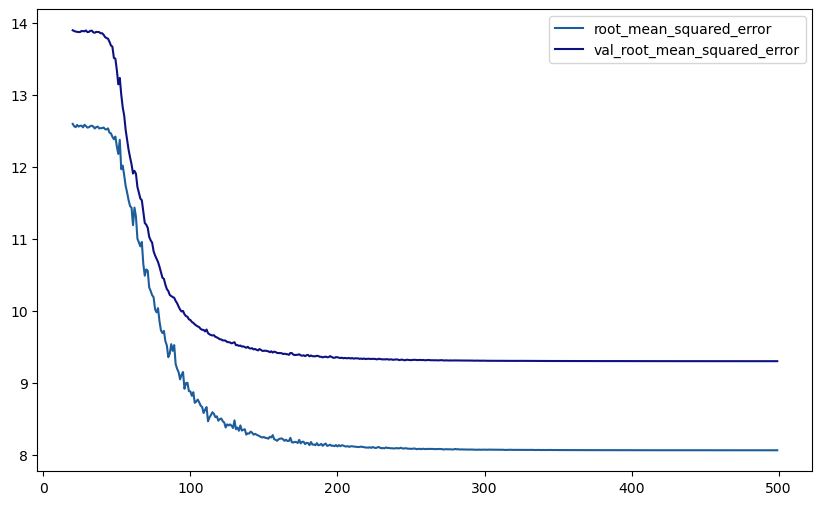

In [118]:
plot_metric(history, 'root_mean_squared_error', 'val_root_mean_squared_error', 20)

In [119]:
temp_vals = group_data.loc[group_data.index.get_level_values(0)>=2020].values[49-window_size:-1]
pred_vals = predict_data(lstm_model, temp_vals, window_size, 12).squeeze()
pred_vals

5/5 [==============================] - 1s 18ms/step


array([ 78.56779 ,  70.052574,  71.68454 ,  84.29609 ,  82.82489 ,
        80.513596,  83.74237 ,  82.65708 ,  81.299286,  81.044334,
        78.72935 ,  78.57446 ,  81.39659 ,  81.391045,  80.20192 ,
       110.158066, 110.81076 , 100.05888 ,  86.34356 ,  78.28995 ,
        76.50227 ,  78.52642 ,  78.93511 ,  81.85418 ,  79.95488 ,
        78.431145,  77.44894 ,  77.45913 ,  76.22431 ,  74.146385,
        73.07445 ,  73.13861 ,  78.93013 ,  80.14408 ,  77.715065,
        77.530396,  78.81325 ,  82.60422 ,  85.01178 ,  84.63135 ,
       102.88527 , 106.64187 ,  98.713036,  94.94601 ,  94.599045,
        87.27029 ,  83.02462 ,  82.0095  ,  84.70282 ], dtype=float32)

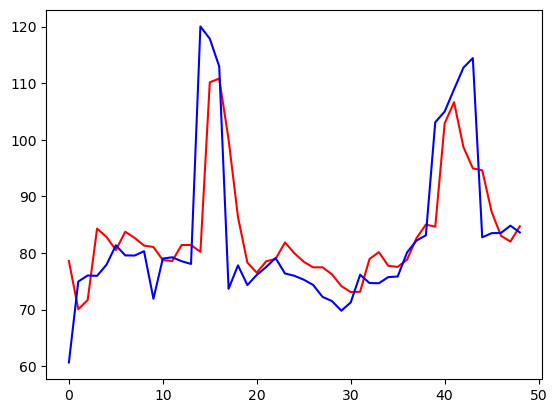

In [120]:
plt.plot(range(49), pred_vals, color='r')
plt.plot(range(49), 
         group_data.loc[group_data.index.get_level_values(0)==2021].values[:49],
         color='b')

In [121]:
# get mean emission by location in 2019
avg_19 = (train_imp.loc[train_imp.year==2019].groupby('location').emission.mean() 
         / train_imp.loc[train_imp.year==2019].emission.mean())
avg_21 = (train_imp.loc[train_imp.year==2021].groupby('location').emission.mean()
         / train_imp.loc[train_imp.year==2021].emission.mean())
avg19_21 = np.divide(avg_19+avg_21, 2)
# print(avg19_21)

In [122]:
make_prediction(avg19_21, pred_vals).ravel()

array([ 4.0762763 ,  3.63448739,  3.71915746, ..., 28.02482796,
       27.68217468, 28.59130096])

In [123]:
y_pred_test = make_prediction(avg19_21, pred_vals).ravel()
sub_df = pd.DataFrame(y_pred_test, index=test_enc.index, columns=['emission'])
sub_df

,emission
ID_LAT_LON_YEAR_WEEK,
ID_-0.510_29.290_2022_00,4.076276
ID_-0.510_29.290_2022_01,3.634487
ID_-0.510_29.290_2022_02,3.719157
ID_-0.510_29.290_2022_03,4.373474
ID_-0.510_29.290_2022_04,4.297144
...,...
ID_-3.299_30.301_2022_44,31.931757
ID_-3.299_30.301_2022_45,29.457947
ID_-3.299_30.301_2022_46,28.024828


In [124]:
sub_df.to_csv('submission.csv')